In [122]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import joblib
import tensorflow as tf

# Fijar la semilla para reproducibilidad
np.random.seed(42)

# Generar un dataset con 1000 muestras
n_samples = 1000

# Crear características simuladas
edad = np.random.randint(20, 70, n_samples)
presion_sanguinea = np.random.randint(90, 180, n_samples)
colesterol = np.random.randint(150, 300, n_samples)
frecuencia_cardiaca = np.random.randint(60, 100, n_samples)

# Crear la variable objetivo binaria
# Para este ejemplo, simularemos que la presencia de la enfermedad (1) está correlacionada con valores altos de las características
enfermedad = (0.3 * edad + 0.3 * presion_sanguinea + 0.3 * colesterol + 0.1 * frecuencia_cardiaca) > 200
enfermedad = enfermedad.astype(int)

# Crear el DataFrame
df = pd.DataFrame({
    'Edad': edad,
    'Presion_Sanguinea': presion_sanguinea,
    'Colesterol': colesterol,
    'Frecuencia_Cardiaca': frecuencia_cardiaca,
    'Enfermedad': enfermedad
})
df.head()

,Edad,Presion_Sanguinea,Colesterol,Frecuencia_Cardiaca,Enfermedad
0,58,122,248,78,0
1,48,142,175,68,0
2,34,111,157,87,0
3,62,110,249,79,0
4,27,159,236,66,0


In [123]:
df2 = df.copy()
print('Número de observaciones (filas) = {}'.format(df2.shape[0]))
print('Total de variables disponibles (columnas) = {} '.format(df2.columns.shape[0]))
print('Columnas que cuentan con un valor nulo -')
print(df2.isnull().sum())

Número de observaciones (filas) = 1000
Total de variables disponibles (columnas) = 5 
Columnas que cuentan con un valor nulo -
Edad                   0
Presion_Sanguinea      0
Colesterol             0
Frecuencia_Cardiaca    0
Enfermedad             0
dtype: int64


In [124]:
import pylab
import scipy.stats as stats

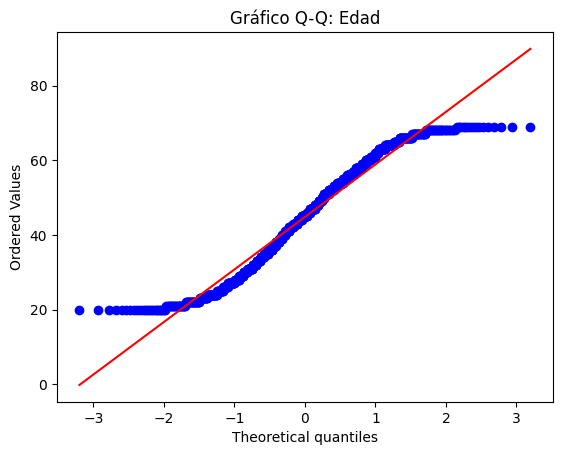

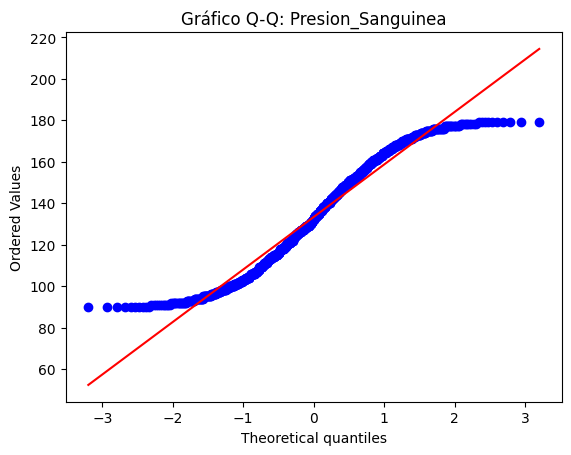

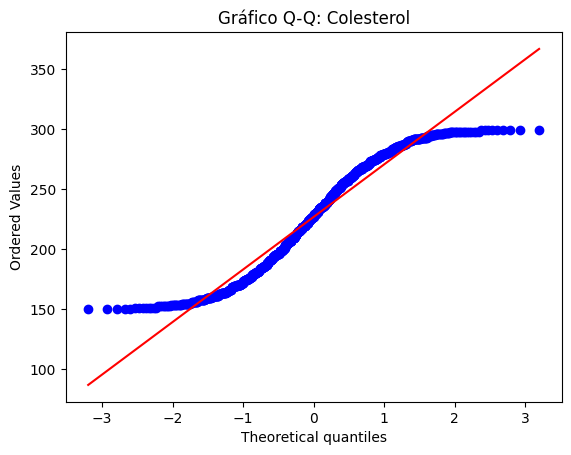

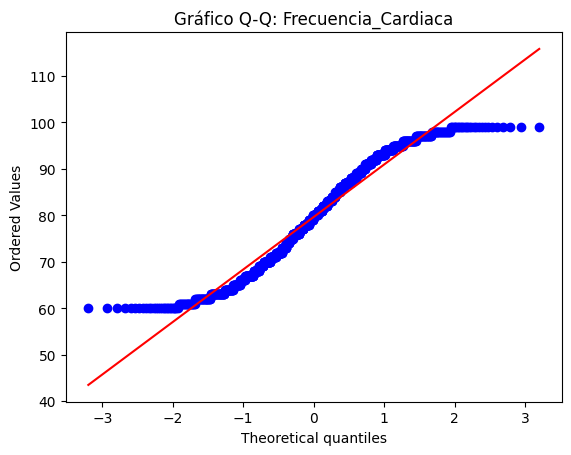

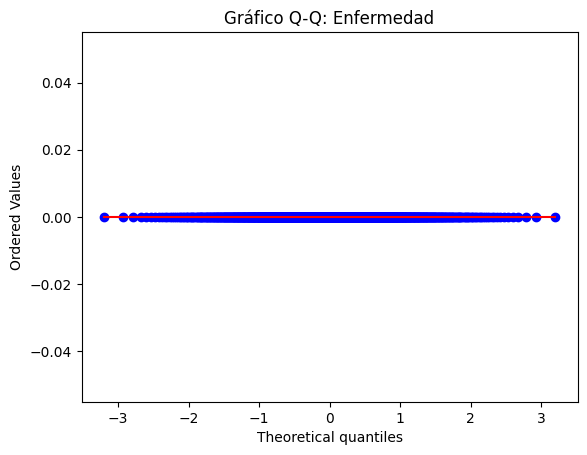

In [125]:
# Función para crear gráficos Q-Q
def crear_quantile(variable, j):
    plt.figure(j)
    stats.probplot(df2[variable], dist="norm", plot=pylab)
    plt.title('Gráfico Q-Q: ' + variable)
    plt.show()

# Generar gráficos Q-Q para cada variable    
variables = ['Edad', 'Presion_Sanguinea', 'Colesterol', 'Frecuencia_Cardiaca','Enfermedad']
j = 0
for variable in variables:
    crear_quantile(variable,j)
    j += 1

In [126]:
from scipy.stats import shapiro

In [127]:
# Función para calcular la prueba de Shapiro-Wilk
def calcular_shapiro(variable):
    estadistico, p_value = stats.shapiro(df2[variable])
    print(f"Estadístico de {variable} = {estadistico: .2f}, p-valor de = {p_value: .4f}")

In [128]:
# Lista de variables
variables = ['Edad', 'Presion_Sanguinea', 'Colesterol', 'Frecuencia_Cardiaca','Enfermedad']

In [129]:
# Calcular la prueba de Shapiro-Wilk para cada variable
for variable in variables:
    calcular_shapiro(variable)

Estadístico de Edad =  0.96, p-valor de =  0.0000
Estadístico de Presion_Sanguinea =  0.96, p-valor de =  0.0000
Estadístico de Colesterol =  0.95, p-valor de =  0.0000
Estadístico de Frecuencia_Cardiaca =  0.95, p-valor de =  0.0000
Estadístico de Enfermedad =  1.00, p-valor de =  1.0000


In [130]:
from sklearn.preprocessing import MinMaxScaler

# Definir caracteristicas numericas y categoricas
numeric_features = ['Edad', 'Presion_Sanguinea', 'Colesterol', 'Frecuencia_Cardiaca']

In [131]:
scaler = MinMaxScaler()
# Aplicar la normalización
df2[numeric_features] = scaler.fit_transform(df2[numeric_features])

# Redes Neuronales

In [132]:
# Definir X e Y

X = df2.drop(columns=['Enfermedad'])
y = df2['Enfermedad']

In [133]:
from sklearn.model_selection import train_test_split
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [134]:
def build_modelo(): 
    oculta = tf.keras.layers.Dense(units=64, activation='relu', input_shape=[X.shape[1]])
    dropout = tf.keras.layers.Dropout(0.3)
    oculta1 = tf.keras.layers.Dense(units=32, activation='relu')
    dropout1 = tf.keras.layers.Dropout(0.3)
    oculta2 = tf.keras.layers.Dense(units=30, activation='relu')
    dropout2 = tf.keras.layers.Dropout(0.3)
    salida = tf.keras.layers.Dense(units=1, activation='sigmoid')
    modelo = tf.keras.Sequential([oculta, dropout, oculta1, dropout1, oculta2, dropout2, salida])
    modelo.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return modelo

In [135]:
modelo = build_modelo()

In [136]:
# Implementar el early_stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [137]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Realizar validación cruzada manualmente
kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = build_modelo()
    model.fit(X_train, y_train, epochs=300, batch_size=64, verbose=False, validation_split=0.2, callbacks=[early_stopping])
    
    val_predictions = (model.predict(X_val) > 0.5).astype("int32")
    val_score = accuracy_score(y_val, val_predictions)
    val_scores.append(val_score)

print(f'Validación cruzada: {val_scores}')
print(f'Promedio de validación cruzada: {np.mean(val_scores)}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Validación cruzada: [1.0, 1.0, 1.0, 1.0, 1.0]
Promedio de validación cruzada: 1.0


In [138]:
# Entrenar el modelo final
model_final = build_modelo()
historial = model_final.fit(X_train, y_train, epochs=300, batch_size=64, verbose=False, validation_split=0.2, callbacks=[early_stopping])

In [139]:
# Evaluar el modelo final en el conjunto de prueba
test_predicciones = (model_final.predict(X_test) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test,test_predicciones)
print(f'Precision en el conjunto de entrenamiento: {test_accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Precision en el conjunto de entrenamiento: 1.0


In [140]:
from sklearn.metrics import classification_report
# Reporte de clasificacion
print('Reporte de clasificación')
print(classification_report(y_test,test_predicciones))

Reporte de clasificación
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



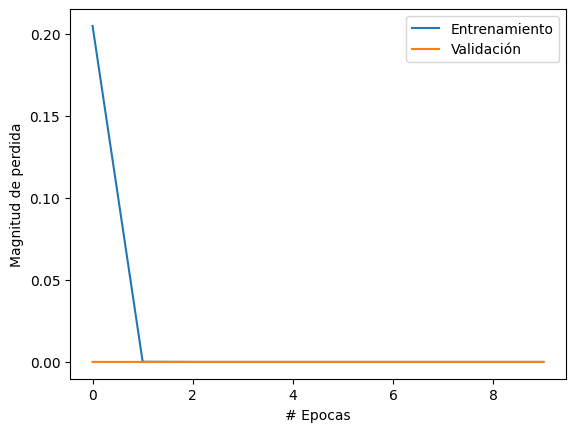

In [141]:
# Graficar la pérdida del modelo final

plt.xlabel('# Epocas')
plt.ylabel('Magnitud de perdida')
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.legend(['Entrenamiento','Validación'])